# Twitter Sentiment Analysis

In [33]:
#!pip install gensim --upgrade
#!pip install keras --upgrade
#!pip install pandas --upgrade
#!pip install Keras-Preprocessing
!pip install --upgrade keras tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [39]:
!pip install scikeras

from scikeras.wrappers import KerasClassifier

Defaulting to user installation because normal site-packages is not writeable
     --------------------------------------- 11.0/11.0 MB 12.1 MB/s eta 0:00:00
     ------------------------------------- 301.8/301.8 kB 18.2 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
print(tf.__version__)

C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


2.16.1


In [42]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
from keras.regularizers import l2

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kwfen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [7]:
file_path = '../../archive/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(file_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [8]:
df.shape

(1600000, 6)

In [9]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [10]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [11]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: total: 46.9 ms
Wall time: 273 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

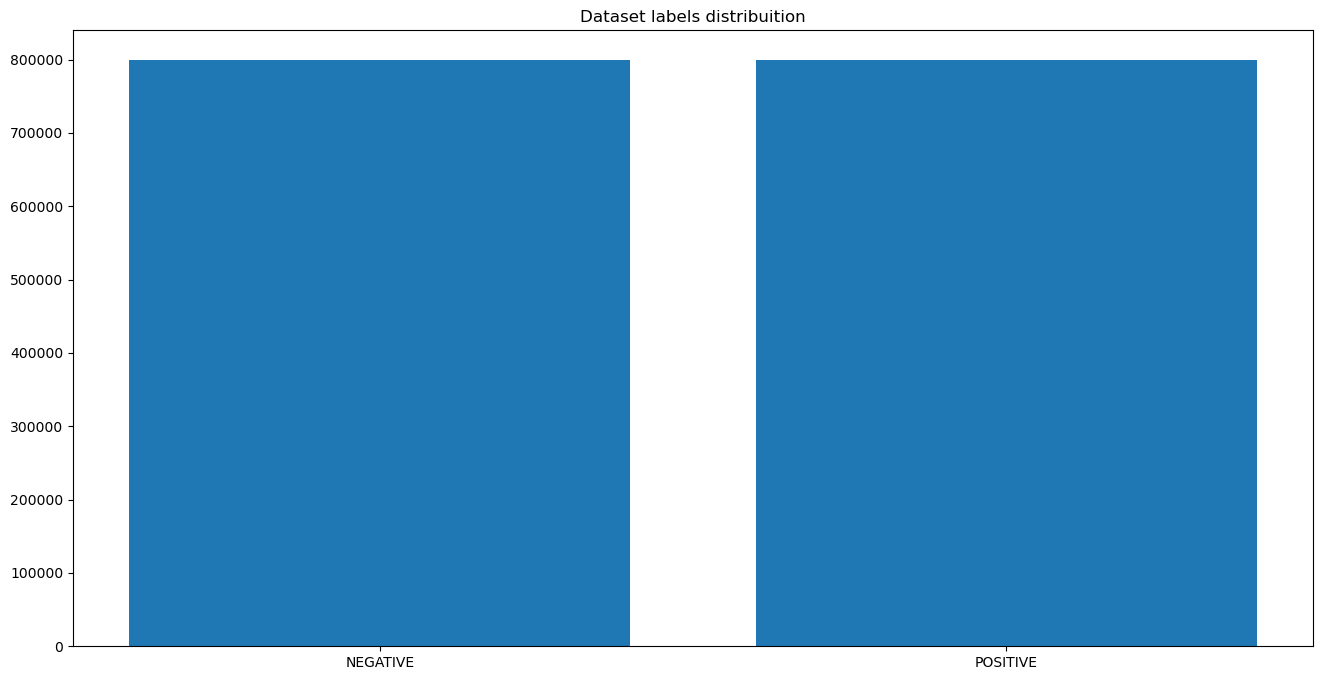

In [12]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [13]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [14]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [15]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 5.12 s
Wall time: 30.5 s


### Split train and test

In [16]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [17]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 1.05 s
Wall time: 3.45 s


In [18]:
W2V_SIZE = 100
W2V_WINDOW = 5
W2V_MIN_COUNT = 1
W2V_WORKERS = 8
w2v_model = gensim.models.Word2Vec(vector_size=W2V_SIZE, 
                                   window=W2V_WINDOW, 
                                   min_count=W2V_MIN_COUNT, 
                                   workers=W2V_WORKERS)

2024-06-14 00:07:41,449 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2024-06-14T00:07:41.449585', 'gensim': '4.3.2', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}


In [19]:
w2v_model.build_vocab(documents)

2024-06-14 00:07:41,464 : INFO : collecting all words and their counts
2024-06-14 00:07:41,464 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-06-14 00:07:41,474 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2024-06-14 00:07:41,487 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2024-06-14 00:07:41,500 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2024-06-14 00:07:41,511 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2024-06-14 00:07:41,522 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2024-06-14 00:07:41,532 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2024-06-14 00:07:41,544 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2024-06-14 00:07:41,554 : INFO : PROGRESS: at s

2024-06-14 00:07:42,302 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2024-06-14 00:07:42,313 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2024-06-14 00:07:42,325 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2024-06-14 00:07:42,338 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2024-06-14 00:07:42,349 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2024-06-14 00:07:42,360 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2024-06-14 00:07:42,372 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2024-06-14 00:07:42,385 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2024-06-14 00:07:42,396 : INFO : PROGRESS: at sentence #800000, processed 577088

In [20]:
# Get the keys from the model's dictionary (the vocabulary)
words = w2v_model.wv.index_to_key

# Calculate vocabulary size
vocab_size = len(words)

print("Vocabulary size:", vocab_size)

Vocabulary size: 290418


In [21]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2024-06-14 00:07:45,786 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 290418 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2024-06-14T00:07:45.786110', 'gensim': '4.3.2', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'train'}
2024-06-14 00:07:46,807 : INFO : EPOCH 0 - PROGRESS: at 30.89% examples, 2683415 words/s, in_qsize 15, out_qsize 0
2024-06-14 00:07:47,808 : INFO : EPOCH 0 - PROGRESS: at 66.80% examples, 2905740 words/s, in_qsize 15, out_qsize 0
2024-06-14 00:07:48,687 : INFO : EPOCH 0: training on 9227204 raw words (8708922 effective words) took 2.9s, 3021440 effective words/s
2024-06-14 00:07:49,696 : INFO : EPOCH 1 - PROGRESS: at 34.35% examples, 2988347 words/s, in_qsize 16, out_qsize 0
2024-06-14 00:07:50,697 : INFO : EPOCH 1 - PROGRESS: at 68.53% examples, 2982922 wor

2024-06-14 00:08:46,969 : INFO : EPOCH 21 - PROGRESS: at 71.78% examples, 3107479 words/s, in_qsize 15, out_qsize 0
2024-06-14 00:08:47,772 : INFO : EPOCH 21: training on 9227204 raw words (8708611 effective words) took 2.8s, 3093265 effective words/s
2024-06-14 00:08:48,801 : INFO : EPOCH 22 - PROGRESS: at 34.35% examples, 2985104 words/s, in_qsize 15, out_qsize 0
2024-06-14 00:08:49,803 : INFO : EPOCH 22 - PROGRESS: at 70.80% examples, 3079774 words/s, in_qsize 16, out_qsize 0
2024-06-14 00:08:50,602 : INFO : EPOCH 22: training on 9227204 raw words (8709213 effective words) took 2.8s, 3106887 effective words/s
2024-06-14 00:08:51,624 : INFO : EPOCH 23 - PROGRESS: at 35.32% examples, 3049654 words/s, in_qsize 15, out_qsize 0
2024-06-14 00:08:52,629 : INFO : EPOCH 23 - PROGRESS: at 72.10% examples, 3122023 words/s, in_qsize 15, out_qsize 0
2024-06-14 00:08:53,380 : INFO : EPOCH 23: training on 9227204 raw words (8709054 effective words) took 2.8s, 3151131 effective words/s
2024-06-14 0

CPU times: total: 37.2 s
Wall time: 1min 30s


(278682774, 295270528)

In [23]:
# Find the most similar words to a given word
similar_words = w2v_model.wv.most_similar("love")

# Print the similar words
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

luv: 0.6613520979881287
loved: 0.6476112008094788
loves: 0.6360829472541809
adore: 0.6337177753448486
amazing: 0.562732458114624
awesome: 0.5539453625679016
loving: 0.5308435559272766
loooove: 0.522794246673584
looooove: 0.5223526358604431
fav: 0.5118126273155212


### Tokenize Text

In [24]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: total: 2.23 s
Wall time: 9.76 s


In [25]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 2.42 s
Wall time: 13.9 s


### Label Encoder 

In [26]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [27]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [28]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [29]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [30]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 100)


In [31]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Build Model

In [91]:
def create_model(optimizer='adam', lstm_units=100, dropout_rate=0.2):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])    
    return model

In [104]:
model = KerasClassifier(model=create_model, verbose=1, dropout_rate=0.2, lstm_units=50)


In [105]:
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'lstm_units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3, 0.4],
#    'batch_size': [32, 64, 128],
#    'epochs': [10, 20]
}

In [106]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

In [107]:
%%time
grid_result = grid.fit(x_train, y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


ValueError: 
All the 54 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_90' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_91' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_92' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_93' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_94' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_95' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_96' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_97' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_98' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_99' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_100' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_101' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_102' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_103' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_104' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_105' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_106' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_107' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_108' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_109' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_110' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_111' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_112' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_113' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_114' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_115' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_116' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_117' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_118' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_119' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_120' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_121' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_122' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_123' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_124' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_125' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_126' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_127' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_128' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_129' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_130' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_131' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_132' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_133' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_134' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_135' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_136' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_137' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_138' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_139' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_140' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_141' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_142' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\models\sequential.py", line 283, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_143' has no defined outputs yet.


In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      29,041,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,041,900 (110.79 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 29,041,900 (110.79 MB)

### Compile model

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [31]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0)
early_stopping = EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5, mode='max')

# List of callbacks
callbacks = [reduce_lr, early_stopping]

### Train

In [32]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 514s 455ms/step - accuracy: 0.7096 - loss: 0.5551 - val_accuracy: 0.7713 - val_loss: 0.4746 - learning_rate: 0.0010
Epoch 2/8


C:\Users\kwfen\AppData\Roaming\Python\Python310\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate
  current = self.get_monitor_value(logs)


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 513s 456ms/step - accuracy: 0.7433 - loss: 0.5126 - val_accuracy: 0.7751 - val_loss: 0.4705 - learning_rate: 0.0010
Epoch 3/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 510s 454ms/step - accuracy: 0.7485 - loss: 0.5059 - val_accuracy: 0.7780 - val_loss: 0.4649 - learning_rate: 0.0010
Epoch 4/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 514s 457ms/step - accuracy: 0.7501 - loss: 0.5021 - val_accuracy: 0.7797 - val_loss: 0.4627 - learning_rate: 0.0010
Epoch 5/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 515s 458ms/step - accuracy: 0.7528 - loss: 0.4999 - val_accuracy: 0.7807 - val_loss: 0.4610 - learning_rate: 0.0010
Epoch 6/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 514s 457ms/step - accuracy: 0.7538 - loss: 0.4978 - val_accuracy: 0.7813 - val_loss: 0.4601 - learning_rate: 0.0010
Epoch 7/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 511s 454ms/step - accuracy: 0.7548 - loss: 0.4963 - val_accuracy: 0.7824 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 8/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 515s 457ms/step - accuracy:

### Evaluate

In [33]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 202ms/step - accuracy: 0.7838 - loss: 0.4545

ACCURACY: 0.7832156419754028
LOSS: 0.4557904303073883
CPU times: total: 27.3 s
Wall time: 1min 3s


In [34]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


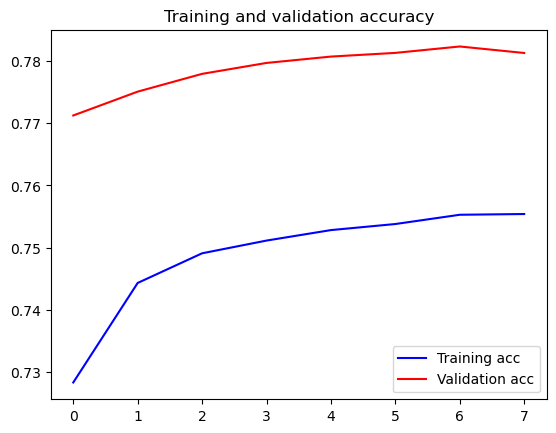

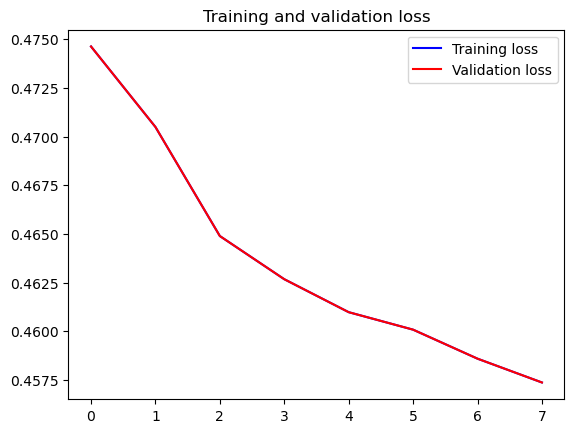

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['val_loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [36]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [37]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [38]:
predict("I love the music")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


{'label': 'POSITIVE',
 'score': 0.9778547286987305,
 'elapsed_time': 0.16188788414001465}

In [39]:
predict("I hate the rain")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


{'label': 'NEGATIVE',
 'score': 0.006396404001861811,
 'elapsed_time': 0.044003963470458984}

In [40]:
predict("i don't know what i'm doing")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


{'label': 'NEUTRAL',
 'score': 0.41038933396339417,
 'elapsed_time': 0.04936528205871582}

In [41]:
predict("I hate the hate speech")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


{'label': 'NEGATIVE',
 'score': 0.015788309276103973,
 'elapsed_time': 0.04004526138305664}

### Confusion Matrix

In [42]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step
CPU times: total: 1min 37s
Wall time: 48.9 s


In [43]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

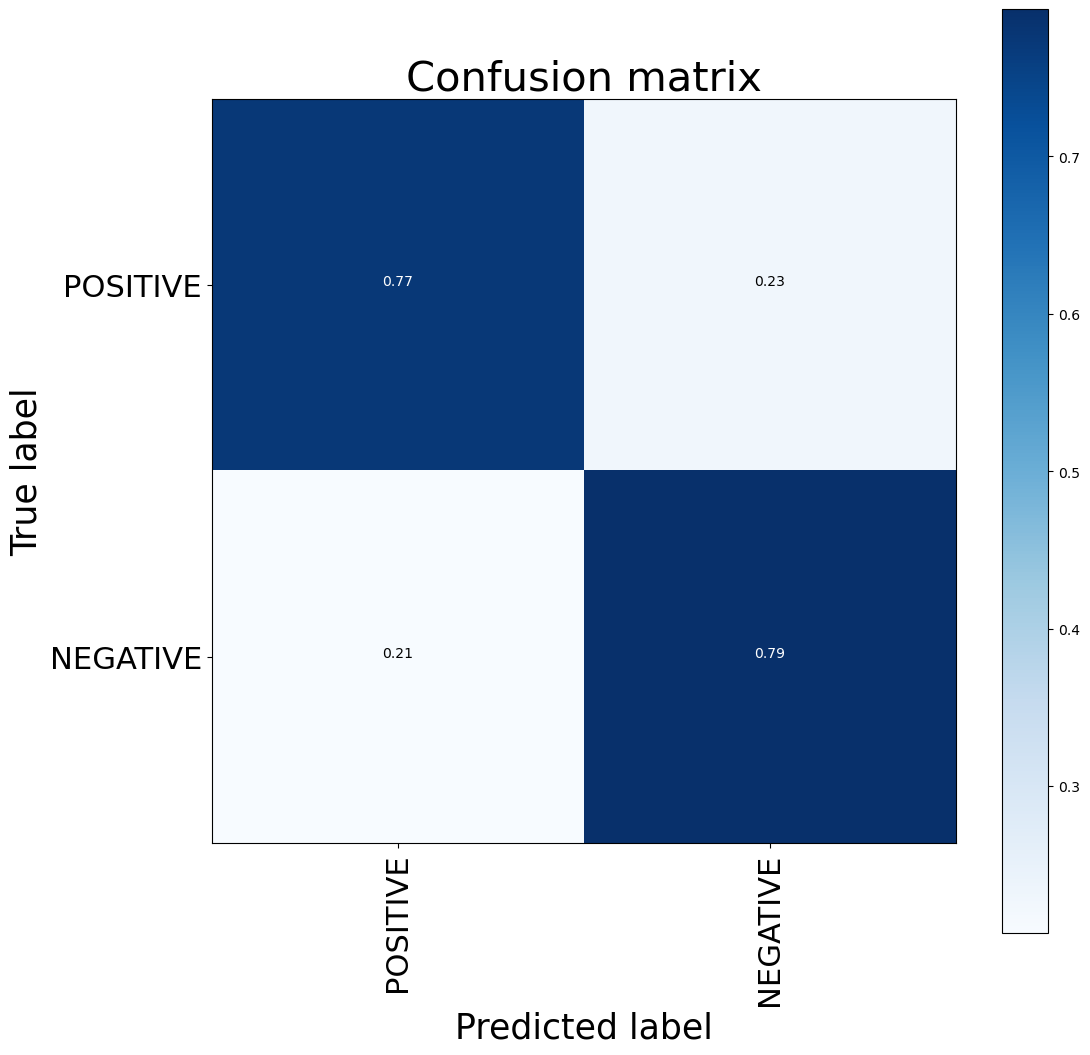

CPU times: total: 297 ms
Wall time: 760 ms


In [44]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [45]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.77      0.78    159494
    POSITIVE       0.78      0.79      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



### Accuracy Score

In [46]:
accuracy_score(y_test_1d, y_pred_1d)

0.783215625

### Save model

In [47]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2024-06-13 14:28:41,505 : WARNING : You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2024-06-13 14:28:41,624 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-06-13T14:28:41.624910', 'gensim': '4.3.2', 'python': '3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'saving'}
2024-06-13 14:28:41,625 : INFO : storing np array 'vectors' to model.w2v.wv.vectors.npy
2024-06-13 14:28:41,695 : INFO : storing np array 'syn1neg' to model.w2v.syn1neg.npy
2024-06-13 14:28:41,766 : INFO : not storing attribute cum_table
2024-06-13 14:28:41,888 : INFO : saved model.w2v
